In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
# Scientific Computing
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats

import bottleneck as bn

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import gsw

from deformtools.tools import *
from deformtools.io import *
from deformtools.methods import *

sns.set(context='talk', style='whitegrid', font_scale=1.3)

In [153]:
def sensitivity_length(N, filt, fu, fv, fzeta):
    '''
    least square method varying length of hexagons
    '''
    f = gsw.f(17)
    M = 3
    llist = np.arange(1, 30, 1).astype(float)
    llist = np.insert(llist, 0, 0.5)
    skew=1
    
    error = []
    error_l = []
    error3 = []
    error_l_ci = []
    for l, L in enumerate(llist):
        # make polygons
        xi, yi = make_n_hexs(L, skew, N, M)

        # find the u,v at the polygon vertices
        ui = fu.ev(xi, yi)
        vi = fv.ev(xi, yi)
        # find zeta at polygon center
        true1 = fzeta.ev(bn.nanmean(xi, axis=1), bn.nanmean(yi, axis=1))/f
        true2 = np.nanmean( fzeta.ev(xi, yi), axis=1)/f

        estimate = np.zeros(N)
        for i in range(N):
            estimate[i], _, _ = least_square_method(
                xi[i, :], yi[i, :], ui[i, :], vi[i, :], 'solve')
        
        # compute R2 and confidence interval
        error.append(stats.pearsonr(true2, estimate)[0]**2)
        error_l.append(stats.pearsonr(true1, estimate)[0]**2)
        error_l_ci.append(bootstrap_ci(true1, estimate, N))
        error3.append( np.nanmean( (estimate-true1)/true1 ) )

    # save in dataframe
    df = pd.DataFrame(index=np.asarray(llist))
    df['error1'] = np.asarray(error)
    df['error2'] = np.asarray(error_l)
    df['error3'] = np.asarray(error3)
    df['ci_low'] = np.asarray(error_l_ci)[:, 0]
    df['ci_high'] = np.asarray(error_l_ci)[:, 1]
    df['filter'] = filt

    return df

def sensitivity_aspect(N, filt, fu, fv, fzeta):
    '''
    least square method varying number of drifter per cluster
    '''
    f = gsw.f(17)
    L = 2
    M = 3
    skewlist = np.arange(1, 30, 1)

    aspect = []
    error = []
    error3 = []
    error_l = []
    error_l_ci = []
    for l, skew in enumerate(skewlist):
        # make polygons
        xi, yi = make_n_hexs(L, skew, N, M)

        # find the u,v at the polygon vertices
        ui = fu.ev(xi, yi)
        vi = fv.ev(xi, yi)
        # find zeta at polygon center
        true1 = fzeta.ev(bn.nanmean(xi, axis=1), bn.nanmean(yi, axis=1))/f
        true2 = np.nanmean( fzeta.ev(xi, yi), axis=1)/f

        estimate = np.zeros(N)
        for i in range(N):
            estimate[i], _, _ = least_square_method(
                xi[i, :], yi[i, :], ui[i, :], vi[i, :], 'lstsq')

        # compute aspect ratio, R2 and confidence interval
        aspect.append(calc_aspect(xi[0, :], yi[0, :]))
        error.append(stats.pearsonr(true2, estimate)[0]**2)
        error_l.append(stats.pearsonr(true1, estimate)[0]**2)
        error_l_ci.append(bootstrap_ci(true1, estimate, N))
        error3.append( np.nanmean( (estimate-true1)/true1 ) )
    
    # save in dataframe
    df = pd.DataFrame(index=np.asarray(aspect))
    df['error1'] = np.asarray(error)
    df['error2'] = np.asarray(error_l)
    df['error3'] = np.asarray(error3)
    df['ci_low'] = np.asarray(error_l_ci)[:, 0]
    df['ci_high'] = np.asarray(error_l_ci)[:, 1]
    df['filter'] = filt

    return df

def sensitivity_number(N, filt, fu, fv, fzeta):
    '''
    least square method varying number of drifter per cluster
    '''
    f = gsw.f(17)
    
    L =2
    mlist = np.arange(3, 10)
    skew=2
    
    error = []
    error3 = []
    error_l = []
    error_l_ci = []
    mad = []
    rms = []
    for l, M in enumerate(mlist):
        # make polygons
        xi, yi = make_n_hexs(L, skew, N, M)

        # find the u,v at the polygon vertices
        ui = fu.ev(xi, yi)
        vi = fv.ev(xi, yi)
        # find zeta at polygon center
        true1 = fzeta.ev(bn.nanmean(xi, axis=1), bn.nanmean(yi, axis=1))/f
        true2 = np.nanmean( fzeta.ev(xi, yi), axis=1)/f

        # estimate vorticity from the velocities
        estimate = np.zeros(N)
        for i in range(N):
            estimate[i], _, _ = least_square_method(
                xi[i, :], yi[i, :], ui[i, :], vi[i, :], 'inv')
        
        # compute R2 and confidence interval
        error.append( stats.pearsonr(true2, estimate)[0]**2)
        error_l.append(stats.pearsonr(true1, estimate)[0]**2)
        error3.append( np.nanmean( (estimate-true1)/true1 ) )
        error_l_ci.append(bootstrap_ci(true1, estimate, N))
        mad.append(np.nanmean( estimate/true1 - np.nanmean(estimate/true1 ) ))
        rms.append(np.nanmean( np.sqrt( (true1 - estimate)**2  )  ))

    # save in dataframe
    df = pd.DataFrame(index=np.asarray(mlist))
    df['error1'] = np.asarray(error)
    df['error2'] = np.asarray(error_l)
    df['error3'] = np.asarray(error3)
    df['mad1'] = np.asarray(mad)
    df['rms1'] = np.asarray(rms)
    df['ci_low'] = np.asarray(error_l_ci)[:, 0]
    df['ci_high'] = np.asarray(error_l_ci)[:, 1]
    df['filter'] = filt

    return df

In [154]:
# %% MAIN
data_path = '../../data/'
zgrid_path = data_path+'psom/zgrid.out'
model_path = data_path+'psom/full_08325.cdf'

# dat = read_model_field(snakemake.input[0], snakemake.input[1])
dat = read_model_field(zgrid_path, model_path) 
dat = dat.rename({'xc':'x'}).rename({'yc':'y'})
dat = dat.set_coords({'x','y'}).transpose('x','y')

fu, fv, fzeta = filter_fields(dat)

In [155]:
N = 1000

length_bucket = []
number_bucket = []
aspect_bucket = []
for i, filt in enumerate([1, 5, 10]):
    length_bucket.append(
        sensitivity_length(N, filt, fu=fu[i], fv=fv[i], fzeta=fzeta[i]))
    number_bucket.append(
        sensitivity_number(N, filt, fu=fu[i], fv=fv[i], fzeta=fzeta[i]))
    aspect_bucket.append(
        sensitivity_aspect(N, filt, fu=fu[i], fv=fv[i], fzeta=fzeta[i]))
    print(filt)

0
10
20


In [156]:
pd.concat(length_bucket).reset_index().to_feather(data_path+'psom/sensitivity_length.feather')
pd.concat(number_bucket).reset_index().to_feather(data_path+'psom/sensitivity_number.feather')
pd.concat(aspect_bucket).reset_index().to_feather(data_path+'psom/sensitivity_aspect.feather')

### Test if comparison checks out

In [83]:
df = pd.concat(number_bucket).reset_index() 

In [114]:
M

20

In [131]:
L = 20
mlist = np.arange(3, 21)
skew=1
N = 1000
f = gsw.f(17)

M=3

error = []
error3 = []
error_l = []
error_l_ci = []
mad = []

# make polygons
xi, yi = make_n_hexs(L, skew, N, M)

# find the u,v at the polygon vertices
ui = fu[2].ev(xi, yi)
vi = fv[2].ev(xi, yi)
# find zeta at polygon center
true1 = fzeta[2].ev(bn.nanmean(xi, axis=1), bn.nanmean(yi, axis=1))/f
true2 = np.nanmean( fzeta[2].ev(xi, yi), axis=1)/f

# estimate vorticity from the velocities
estimate = np.zeros(N)
for i in range(N):
    estimate[i], _, _ = least_square_method(
        xi[i, :], yi[i, :], ui[i, :], vi[i, :], 'inv')

# compute R2 and confidence interval
error3.append( np.nanmean( (estimate-true1)/true1 ) )
error.append( stats.pearsonr(true2, estimate)[0]**2)
error_l.append(stats.pearsonr(true1, estimate)[0]**2)
error_l_ci.append(bootstrap_ci(true1, estimate, N))
mad.append(np.nanmean( estimate/true1 - np.nanmean(estimate/true1 ) ))

(array([ 38.,  92., 190., 173., 172., 187.,  87.,  36.,  18.,   7.]),
 array([-0.60219743, -0.44830177, -0.29440611, -0.14051045,  0.01338521,
         0.16728086,  0.32117652,  0.47507218,  0.62896784,  0.7828635 ,
         0.93675916]),
 <a list of 10 Patch objects>)

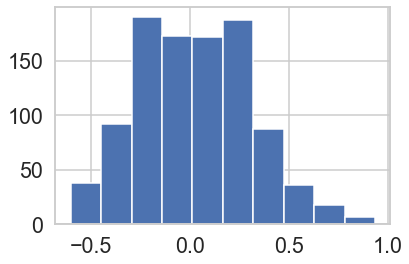

In [132]:
plt.hist(estimate)

(array([ 22.,  78., 142., 171., 151., 135., 153.,  99.,  34.,  15.]),
 array([-0.51970181, -0.40282082, -0.28593982, -0.16905883, -0.05217784,
         0.06470315,  0.18158414,  0.29846513,  0.41534612,  0.53222711,
         0.6491081 ]),
 <a list of 10 Patch objects>)

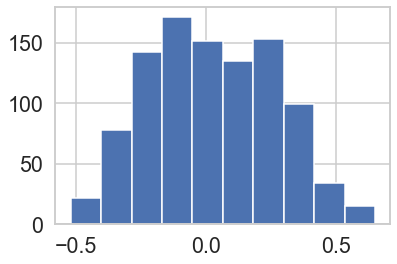

In [133]:
plt.hist(true2)

In [134]:
np.nanmean( np.sqrt( (true1 - estimate)**2  )  )

0.1298689483989886